# Projet A/B testing

## importation des modules et chargement

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

In [3]:
# Charger le dataset
df = pd.read_csv('ab_data.csv')

# Aperçu des données
print(df.head())
print(df.info())

# Vérifier les valeurs manquantes
print(df.isnull().sum())

# Vérifier la répartition des groupes
print(df['group'].value_counts())

   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None
user_id         0
timestamp       0
group           0
landing_page    0
converted       0

## Nettoyage des Données

In [4]:
# Vérifier les incohérences
inconsistent = df[((df['group'] == 'control') & (df['landing_page'] != 'old_page')) |
                  ((df['group'] == 'treatment') & (df['landing_page'] != 'new_page'))]
print(f"Incohérences trouvées : {len(inconsistent)}")

# Supprimer les incohérences
df_clean = df[~df.index.isin(inconsistent.index)]

# Supprimer les doublons d'utilisateurs
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')

# Vérifier la taille du dataset nettoyé
print(f"Taille du dataset après nettoyage : {df_clean.shape}")

Incohérences trouvées : 3893
Taille du dataset après nettoyage : (290584, 5)


## Analyse Exploratoire

Taux de conversion :
group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64


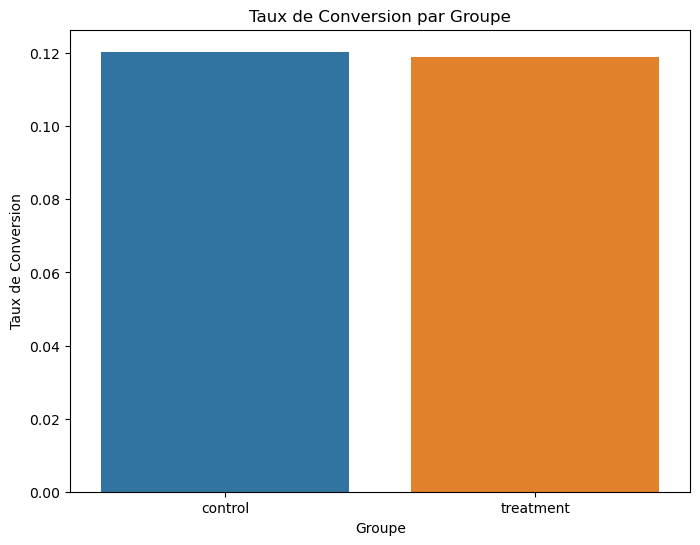

In [6]:
# Taux de conversion par groupe
conversion_rates = df_clean.groupby('group')['converted'].mean()
print("Taux de conversion :")
print(conversion_rates)

# Visualisation
plt.figure(figsize=(8, 6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values, hue=conversion_rates.index, palette=['#1f77b4', '#ff7f0e'], legend=False)
plt.title('Taux de Conversion par Groupe')
plt.ylabel('Taux de Conversion')
plt.xlabel('Groupe')
plt.show()

## Test Statistique
H0 : Les taux de conversion des deux groupes sont égaux.
H1 : Les taux de conversion sont différents.

In [7]:
# Tableau de contingence
contingency_table = pd.crosstab(df_clean['group'], df_clean['converted'])
print("Tableau de contingence :")
print(contingency_table)

# Test du chi²
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi² : {chi2}, p-value : {p_value}")

# Interprétation
if p_value < 0.05:
    print("La différence est statistiquement significative (rejet de H0).")
else:
    print("Pas de différence significative (on ne rejette pas H0).")

Tableau de contingence :
converted       0      1
group                   
control    127785  17489
treatment  128046  17264
Chi² : 1.7035660051885058, p-value : 0.19182228096235662
Pas de différence significative (on ne rejette pas H0).


## Visualisation Finale

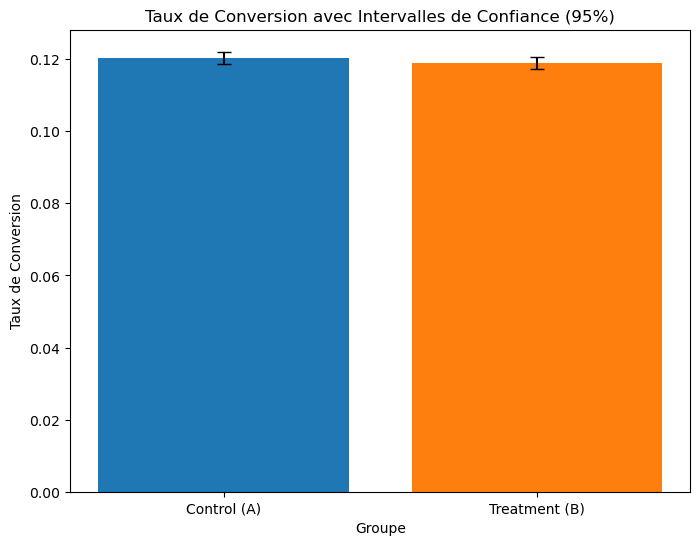

In [9]:
# Création d'un graphique avec intervalle de confiance
# Calcul des intervalles de confiance
conv_a = df_clean[df_clean['group'] == 'control']['converted']
conv_b = df_clean[df_clean['group'] == 'treatment']['converted']

ci_a = proportion_confint(conv_a.sum(), conv_a.count(), alpha=0.05)
ci_b = proportion_confint(conv_b.sum(), conv_b.count(), alpha=0.05)

# Données pour le graphique
groups = ['Control (A)', 'Treatment (B)']
rates = [conv_a.mean(), conv_b.mean()]
errors = [(rates[0] - ci_a[0]), (rates[1] - ci_b[0])]

# Création du graphique
plt.figure(figsize=(8, 6))
plt.bar(groups, rates, yerr=errors, capsize=5, color=['#1f77b4', '#ff7f0e'])
plt.title('Taux de Conversion avec Intervalles de Confiance (95%)')
plt.ylabel('Taux de Conversion')
plt.xlabel('Groupe')
plt.show()

In [10]:
from statsmodels.stats.power import NormalIndPower

# Paramètres
alpha = 0.05  # Seuil de significativité
power = 0.8   # Puissance souhaitée
conv_control = df_clean[df_clean['group'] == 'control']['converted'].mean()
conv_treatment = df_clean[df_clean['group'] == 'treatment']['converted'].mean()
effect_size = abs(conv_control - conv_treatment) / ((conv_control * (1 - conv_control) + conv_treatment * (1 - conv_treatment)) ** 0.5)

# Calcul de la taille d'échantillon nécessaire
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)
print(f"Taille d'échantillon nécessaire par groupe : {sample_size:.0f}")

# Vérification
n_control = len(df_clean[df_clean['group'] == 'control'])
print(f"Taille réelle du groupe control : {n_control}")
if n_control >= sample_size:
    print("L'échantillon est suffisamment grand.")
else:
    print("L'échantillon est sous-dimensionné, risque de faible puissance.")

Taille d'échantillon nécessaire par groupe : 1327153
Taille réelle du groupe control : 145274
L'échantillon est sous-dimensionné, risque de faible puissance.
